<a href="https://colab.research.google.com/github/RachelRamirez/FashionMNIST_DataAugmentation/blob/main/9_1_2021_1832_Fashion_mnist_convnet_dealing_with_contrast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Simple (Fashion) MNIST convnet" Architecture with Extremely Limited Data used to Train CNN

**Original Author with MNIST:** [fchollet](https://twitter.com/fchollet)<br>
Date created: 2015/06/19<br>

**Modified to Fashion MNIST** [rachelramirez](https://github.com/RachelRamirez/FashionMNIST_DataAugmentation) 2021/08/25

**Description:** A simple convnet architecture for training on Fashion MNIST, is frozen and then data augmentation techniques are attempted as a Design of Experiment (DOE).

Then data is limited to varying levels of sample sizes  [500, 1000]  to view the effect of data augmentation on increasing model accuracy.

More features are added to original notebook for residual/error analysis such as confusion matrix and data augmentation.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Sep  6 21:51:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files
from keras.layers import GaussianNoise
from sklearn.metrics import plot_confusion_matrix

print(tf. __version__) 



from datetime import datetime


2.6.0


# Experiment

The first part of this experiment is looking at the space for *TrainingSize*, *ValidationSize*, *BatchSize*, and *EpochSize*.  These all likely effect one another (4-way interactions) so a DOE design is used to look at Response Surface Methods.

A: BatchSize (10, 100)

B: Epochs  (15, 50)

C: Training Size (Count)  (100, 1000)

D: Validation (as percentage of Training Size)  (20%, 50%) 

Replicates: 2
Center Points: 1

## Prepare the data

AxesSubplot(0.125,0.125;0.775x0.755)


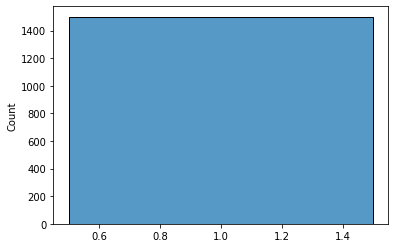

In [12]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Until the end of all analysis I don't really want to look at the real test set results
# I'm overwriting them to make sure I don't accidentally use them

x_test = []
y_test = []




# I decide to take a small dataset - 2000 samples of the 60000, and use that to 
# create a TRAIN Set of up to 1000 samples, a VALIDATION Set of up to 1000 samples, and a FAKE-TEST set of the remaining 58000
# After Analyzing the best "Augmentation Effect" I wil apply it to the "REAL" Test DataSet to see if it improved.


# Validation Set is 1000 --> 500 
x_val = x_train[1500:2000]
y_val = y_train[1500:2000]

#My FAKE Test Set is 58000
x_test = x_train[2000:60000]
y_test = y_train[2000:60000]


# Finally I change train dataset to first 1000
x_train = x_train[0:1]
y_train = y_train[0:1500]

hist= sn.histplot(y_train)
print(hist)
#My holdout Test Set after all the DOE is the original TEST set from dataset


print("Fashion MNIST has training size up to: ", y_train.shape, ", val set of , ", y_val.shape, " and test set of ", y_test.shape)


# Scale images to the [0, 1] range
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255    # put into preprocessing model step
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], "fake test samples saved from test-set")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Try to put in tensor flow shape
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)


# Define Manual Validation Set
valid_set = (x_val, y_val)


Class 2 looks a bit underrepresented, class 7 looks overrepresented in first 1000.  I looked at 1500 and it seemed more balanced

## Image Augmentation Factors 

Augmentation_Building Function to build Data Augmentation Layer in Keras

In [4]:
def augmentation_building(flip, c, r, n, z,randseed=42, num_classes = 10, input_shape = (28, 28, 1)):  

  if flip == 0:
    flip_layer      = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
    flip_layer     = layers.experimental.preprocessing.RandomFlip("horizontal", seed = randseed, name = "FlipHorizontal")

  if r == 0:
    rotate_layer    = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
    rotate_layer   = layers.experimental.preprocessing.RandomRotation(factor = r, seed = randseed, name = "Rotate")

  if c == 0:
    contrast_layer  = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
    contrast_layer = layers.experimental.preprocessing.RandomContrast(factor=c, seed = randseed, name = "Contrast") 

  if n == 0:
    noise_layer     = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
   noise_layer    = layers.GaussianNoise(n, name = "GaussianNoise")


  if z == 0:
    zoom_layer      = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
    zoom_layer     = layers.experimental.preprocessing.RandomZoom(height_factor=z, fill_mode="constant", fill_value=0.0, name="zoom")

  
  data_augmentation = tf.keras.Sequential([
    flip_layer,  
    rotate_layer,  
    contrast_layer, 
    noise_layer,
    zoom_layer  
  ])
 

  model = keras.Sequential(
  [
      keras.Input(shape=input_shape),
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
      data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax")
  ])
  
  return model


In [5]:
# All Variable Settings
#var_batches =   64, 128  #batch
#var_epochs =  50, 100 #epoch


var_trainsize  = 100, 505, 1000, 1500
var_flip = 0, 1                     # 0 means no flip, 1 means horizontal flip
var_contrast = 0, 0.01, 0.05, 0.1   # 0.001, 0.01, 0.1    # 0 means no contrast (I think) and 1.02 means contrast difference of 0.02  (I think)
var_rotate = 0, 0.01, 0.05, 0.1     #0.025, .05       # 0.5 means rotate between -5 and 5 degrees
var_noise = 0, 0.01, 0.01, 0.1       #0.05, .1         # 0 means no noise, 0.1 means 10% noise
var_zoom = 0, 0.01, 0.01, 0.1        #0.05, .1



best_100_run_score = 0.5
best_505_run_score = 0.5
best_1000_run_score = 0.5
best_1500_run_score = 0.5

best_100_run_record = []
best_505_run_record = []
best_1000_run_record = []
best_1500_run_record = []

scorelist = []

#header = ['counter  epochs  batches   trainsize  flip  contrast  rotate  noise zoom   accuracy   loss']
# scorelist +=  [[counter, e, b,  t,  flip ,c,  r,  n,  z,  score[0], score[1] ]]


counter = 0
#for b in var_batches:
#  for e in var_epochs:
b = 64
e = 100

for t in var_trainsize:

  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]
  print(new_y_train.shape)

  for flip in var_flip:
    for c in var_contrast:
      for r in var_rotate:
        for n in var_noise:
          for z in var_zoom:
            
            counter+=1
            model = augmentation_building(flip, c, r, n, z)
                  


            callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
            model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            model.save_weights('model_clear.h5') 
            model.load_weights('model_clear.h5')
            
            
            #start_time = datetime.now()
            history = model.fit(new_x_train, new_y_train, batch_size=b, epochs=e,  validation_data=valid_set, verbose=0, callbacks=callback)
            #end_time = datetime.now()
            #dur = end_time - start_time

            score = model.evaluate(x_test, y_test, verbose=0)

            scorelist +=  [[counter, e, b,  t,  flip ,c,r,n,z,  score[1], score[0]]]
            print("Run: ", counter, b, e,  t, flip,c,r,n, z, "Accuracy: ", format(score[1], ".4f"), " Loss: ", format(score[0], ".4f"))
            # filename = str(t) + '-' + str(i) + '-' + str(c) + '-' + str(r) +  '-' +  str(n) + str(z) + str('.csv')
            

            
            filename = "Batch" + str(b) + " " +  str(t) + 'T-' + str(flip) + 'F-' + str(c) + "C-" +  str(r) + "R-" +  str(n) + "N-" + str(z) + "Z" + str('.csv')


            #Keep tabs on the best performing 100-run models
            if t == 100 and score[1] > best_100_run_score:
              best_100_run_score = score[1]
              best_100_run_record = [counter, "Batches: ", b, "Epochs: ", e, "Train: ", t, "Flip: ", flip, "Contrast: ", c, "Rotate: ", r, "Noise: ", n, "Zoom: ", z ]
              model.save_weights('model_best100.h5') 


              #Keep tabs on the best performing 505-run models
            if t == 505 and score[1] > best_505_run_score:
              best_505_run_score = score[1]
              best_505_run_record = [counter, "Batches: ", b, "Epochs: ", e, "Train: ", t, "Flip: ", flip, "Contrast: ", c, "Rotate: ", r, "Noise: ", n, "Zoom: ", z ]
              model.save_weights('model_best505.h5') 


              #Keep tabs on the best performing 1000-run models
            if t == 1000 and score[1] > best_1000_run_score:
              best_1000_run_score = score[1]
              best_1000_run_record = [counter, "Batches: ", b, "Epochs: ", e, "Train: ", t, "Flip: ", flip, "Contrast: ", c, "Rotate: ", r, "Noise: ", n, "Zoom: ", z ]
              model.save_weights('model_best1000.h5') 

              #Keep tabs on the best performing 1000-run models
            if t == 1500 and score[1] > best_1500_run_score:
              best_1500_run_score = score[1]              
              best_1500_run_record = [counter, "Batches: ", b, "Epochs: ", e, "Train: ", t, "Flip: ", flip, "Contrast: ", c, "Rotate: ", r, "Noise: ", n, "Zoom: ", z ]
              model.save_weights('model_best1500.h5') 

  
  np.savetxt(filename, scorelist, delimiter=',')




# #Center Points
# var_trainsize  = 100, 505, 1000
# var_flip = 0, 1           # 0 means no flip, 1 means horizontal flip
# var_contrast = 0.00001,   0.01     # 0.02    # 0 means no contrast (I think) and 1.02 means contrast difference of 0.02  (I think)
# var_rotate = 0, 0.025            #.05       # 0.5 means rotate between -5 and 5 degrees
# var_noise = 0, 0.05             #.1         # 0 means no noise, 0.1 means 10% noise


(100, 10)
Run:  1 64 100 100 0 0 0 0 0 Accuracy:  0.7247  Loss:  0.8212
Run:  2 64 100 100 0 0 0 0 0.01 Accuracy:  0.7115  Loss:  0.9132
Run:  3 64 100 100 0 0 0 0 0.01 Accuracy:  0.6883  Loss:  0.9820
Run:  4 64 100 100 0 0 0 0 0.1 Accuracy:  0.7027  Loss:  0.8472
Run:  5 64 100 100 0 0 0 0.01 0 Accuracy:  0.7033  Loss:  0.9346
Run:  6 64 100 100 0 0 0 0.01 0.01 Accuracy:  0.7022  Loss:  0.8342
Run:  7 64 100 100 0 0 0 0.01 0.01 Accuracy:  0.6961  Loss:  0.9124
Run:  8 64 100 100 0 0 0 0.01 0.1 Accuracy:  0.7148  Loss:  0.8241
Run:  9 64 100 100 0 0 0 0.01 0 Accuracy:  0.7170  Loss:  0.8388
Run:  10 64 100 100 0 0 0 0.01 0.01 Accuracy:  0.7121  Loss:  0.8583
Run:  11 64 100 100 0 0 0 0.01 0.01 Accuracy:  0.7090  Loss:  0.8399
Run:  12 64 100 100 0 0 0 0.01 0.1 Accuracy:  0.7039  Loss:  0.8659
Run:  13 64 100 100 0 0 0 0.1 0 Accuracy:  0.7105  Loss:  0.8177
Run:  14 64 100 100 0 0 0 0.1 0.01 Accuracy:  0.7093  Loss:  0.8683
Run:  15 64 100 100 0 0 0 0.1 0.01 Accuracy:  0.7069  Loss:  0

Function to build model in for-loop

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


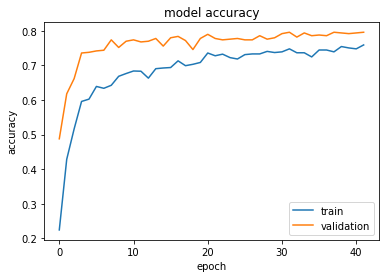

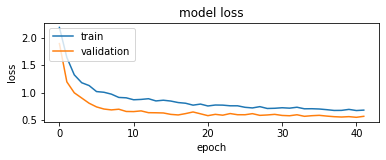

100: 0.7283275723457336 [175, 'Batches: ', 64, 'Epochs: ', 100, 'Train: ', 100, 'Flip: ', 0, 'Contrast: ', 0.05, 'Rotate: ', 0.05, 'Noise: ', 0.1, 'Zoom: ', 0.01]
500-505:  0.813724160194397 [522, 'Batches: ', 64, 'Epochs: ', 100, 'Train: ', 505, 'Flip: ', 0, 'Contrast: ', 0, 'Rotate: ', 0, 'Noise: ', 0.01, 'Zoom: ', 0.01]
1000: 0.8306896686553955 [1045, 'Batches: ', 64, 'Epochs: ', 100, 'Train: ', 1000, 'Flip: ', 0, 'Contrast: ', 0, 'Rotate: ', 0.01, 'Noise: ', 0.01, 'Zoom: ', 0]
1500: 0.8388448357582092 [1733, 'Batches: ', 64, 'Epochs: ', 100, 'Train: ', 1500, 'Flip: ', 0, 'Contrast: ', 0.1, 'Rotate: ', 0, 'Noise: ', 0.01, 'Zoom: ', 0]


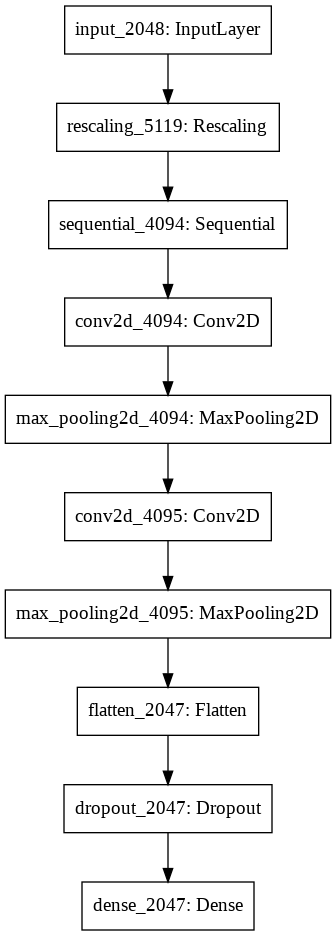

In [8]:
    print(history.history.keys())
    plt.figure(counter+1)

    # plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 


print("100:", best_100_run_score, best_100_run_record)
#print("500-505: ", best_505_run_score, best_500_run_record)
print("500-505: ", best_505_run_score, best_505_run_record)
print("1000:", best_1000_run_score, best_1000_run_record)
print("1500:", best_1500_run_score, best_1500_run_record)


tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)


In [ ]:

!pip install h5py==2.10.0

## Evaluate the trained model

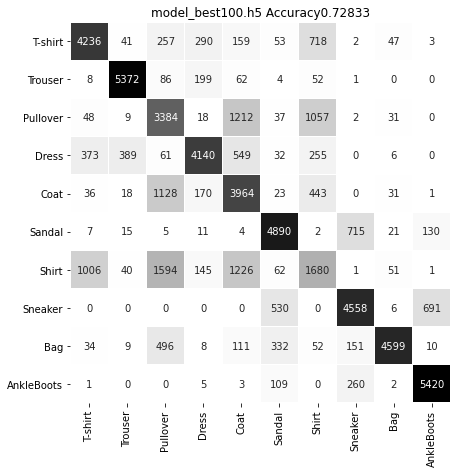

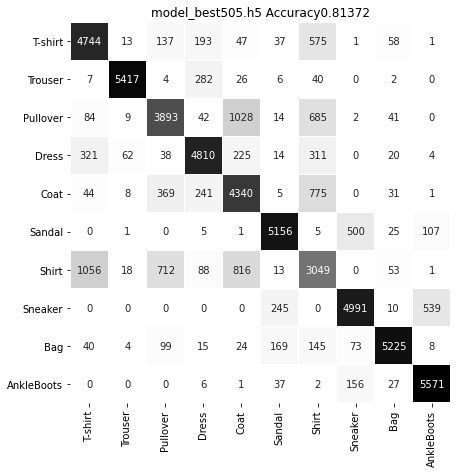

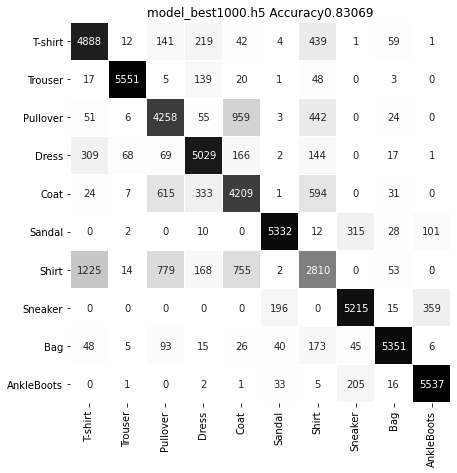

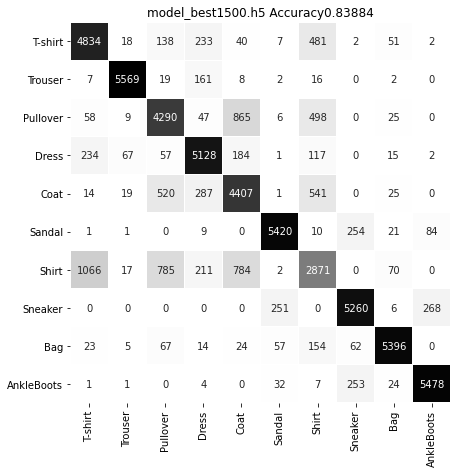

In [13]:
LABEL_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoots']
modelnames = ['model_best100.h5', 'model_best505.h5', 'model_best1000.h5', 'model_best1500.h5']
best_accuracy = [best_100_run_score, best_505_run_score, best_1000_run_score,  best_1500_run_score]


y_test = np.argmax(y_test, axis=1) 

for modelname, best_accuracy in zip(modelnames, best_accuracy):
  model.load_weights(modelname)

  predictions = model.predict(x_test)
  predictions = np.argmax(predictions, axis=1)
  
  

  confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
  #confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))
  
  # plot_confusion_matrix(model, x_test, y_test, display_labels=LABEL_NAMES, cmap=plt.cm.Blues, normalize=True)
  title = str(modelname + " Accuracy" ) + str(round(best_accuracy, ndigits=5))

  f, ax = plt.subplots(figsize=(9, 7))
  sn.heatmap(
      confusion_matrix,
      annot=True,
      linewidths=.5,
      fmt="d",
      square=True
      ,cmap=plt.cm.gray_r
      ,cbar=False
      ,xticklabels=LABEL_NAMES
      ,yticklabels=LABEL_NAMES
      #,display_labels=LABEL_NAMES
      #,ax=ax
  )






  plt.title(title)
  plt.show()


In my first run, no data augmentation, 100 random samples of the Training Set, using 50% of that as the Validation Set, using a Batch Size of 50 and Epochs = 30, the resulting accuracy of the test-set is Test loss: 0.912209689617157
Test accuracy: 0.6866999864578247

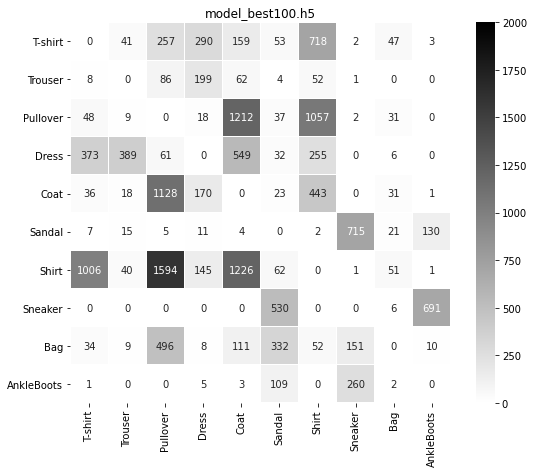

The algorithm misrecognizes  1594.0   of class  Shirt  as class  Pullover


<tf.Tensor: shape=(), dtype=float64, numpy=15757.0>

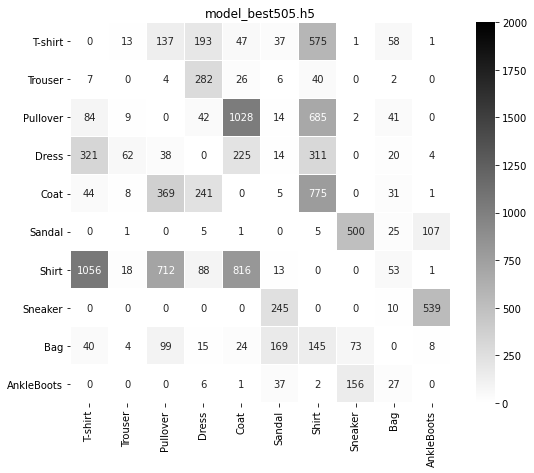

The algorithm misrecognizes  1056.0   of class  Shirt  as class  T-shirt


<tf.Tensor: shape=(), dtype=float64, numpy=10804.0>

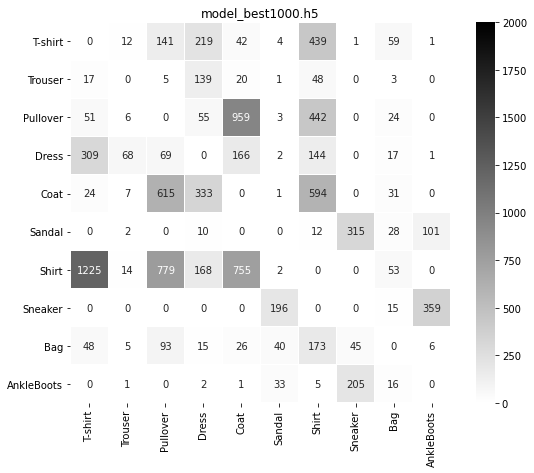

The algorithm misrecognizes  1225.0   of class  Shirt  as class  T-shirt


<tf.Tensor: shape=(), dtype=float64, numpy=9820.0>

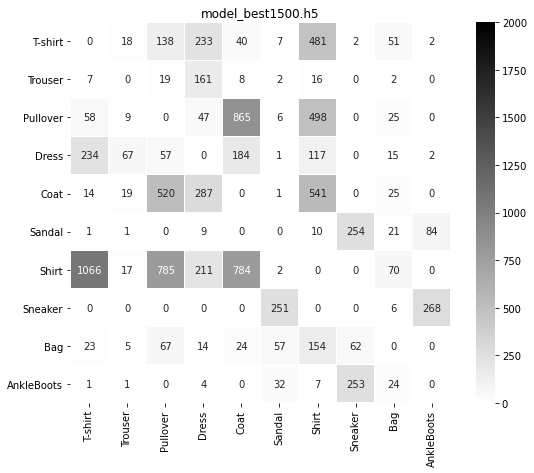

The algorithm misrecognizes  1066.0   of class  Shirt  as class  T-shirt


<tf.Tensor: shape=(), dtype=float64, numpy=9347.0>

In [16]:
### Just the confusing part
LABEL_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoots']
modelnames = ['model_best100.h5', 'model_best505.h5', 'model_best1000.h5', 'model_best1500.h5']
  
for modelname in modelnames:
  model.load_weights(modelname)

  predictions = model.predict(x_test)
  predictions = np.argmax(predictions, axis=1)
  
  confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
  #confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))
  
  # plot_confusion_matrix(model, x_test, y_test, display_labels=LABEL_NAMES, cmap=plt.cm.Blues, normalize=True)
  title = str(modelname)



  ## I want to pick the largest value on the confusion matrix not on the diagonal
  confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)

  confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)

  # f, ax = plt.subplots(figsize=(9, 7))
  # sn.heatmap(
  #     confusing_part_matrix,
  #     annot=True,
  #     linewidths=.5
  #     ,fmt='.0f'
  #     #,fmt="d"
  #     #,square=True
  #     #,ax=ax
  # )
  # plt.show()


  title = str(modelname)

  f, ax = plt.subplots(figsize=(9, 7))
  sn.heatmap(
      confusing_part_matrix,
      annot=True,
      linewidths=.5
      ,fmt='.0f'
      ,square=True
      ,cmap=plt.cm.gray_r
      ,cbar=True
      ,vmax=2000
      ,xticklabels=LABEL_NAMES
      ,yticklabels=LABEL_NAMES
      #,display_labels=LABEL_NAMES
      #,ax=ax
  )





  
  plt.title(title)
  plt.show()


  ## find the max value of those remaining numbers
  thisnumber=np.max(confusing_part_matrix)

  # x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
  # y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
  # z_thisnumber=np.argmax(confusing_part_matrix)
  # display(x_thisnumber,y_thisnumber)
  # print("The worst the algorithm did is between " confus)
  z_thisnumber=np.argmax(confusing_part_matrix)
  z_thisnumber
  print("The algorithm misrecognizes ", thisnumber, "  of class " ,  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " as class ",  LABEL_NAMES[z_thisnumber%10])


  display(sum(sum(confusing_part_matrix)))
  

In [ ]:
plt.imshow(x_test[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

Evaluate the "Winning Augmentations" for Holdout Data

In [37]:
print(" This is applying the augmentations to the holdout data set to see which one was better")


e = 100
b = 64

# oldscorelist = scorelist
# scorelist  =[]

#Reload Real Test Data (the holdout data) 
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


# # Validation Set is 1000 
x_val = x_train[1000:2000]
y_val = y_train[1000:2000]
 

# # Finally I change train dataset to first 1000
x_train = x_train[0:1000]
y_train = y_train[0:1000]



print("Fashion MNIST has training size up to: ", y_train.shape, ", val set of , ", y_val.shape, " and test set of ", y_test.shape)


# Scale images to the [0, 1] range
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255    # put into preprocessing model step
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], "fake test samples saved from test-set")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# # Try to put in tensor flow shape
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)


# # Define Manual Validation Set
valid_set = (x_val, y_val)

var_trainsize  = 100, 505, 1000, 1500
var_noise = 0, 0.1     #0.05, .1         # 0 means no noise, 0.1 means 10% noise


scorelist = []

counter = 0
b = 64
e = 100

for t in var_trainsize:

  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]
  print(new_y_train.shape)

  flip = 0
  c = 0
  r = 0
  z = 0

  for n in var_noise:
    # for z in var_zoom:
      
      counter+=1
      modelaugmented = augmentation_building(flip, c, r, n, z)
            
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
      modelaugmented.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
      modelaugmented.save_weights('model_clear.h5') 
      modelaugmented.load_weights('model_clear.h5')
      
      
      #start_time = datetime.now()
      history = modelaugmented.fit(new_x_train, new_y_train, batch_size=b, epochs=e,  validation_data=valid_set, verbose=0, callbacks=callback)
      #end_time = datetime.now()
      #dur = end_time - start_time

      score = modelaugmented.evaluate(x_test, y_test, verbose=0)

      scorelist +=  [[counter, e, b,  t,  flip ,c,r,n,z,  score[1], score[0]]]
      print("Run: ", counter,  t, flip,c,r,n, z, "Accuracy: ", format(score[1], ".4f"), " Loss: ", format(score[0], ".4f"))
   
      filename = "Holdout " + str(t) + 'T-' +  str(n) + "N-" + str('.csv')



      if  n > 0  :
        modelname = str(t) + str('augmented.h5')
        modelaugmented.save_weights(modelname) 
      else:
        modelname = str(t) + str("notaugmented.h5")
        modelaugmented.save_weights(modelname)

  np.savetxt(filename, scorelist, delimiter=',')

 This is applying the augmentations to the holdout data set to see which one was better
Fashion MNIST has training size up to:  (1000,) , val set of ,  (1000,)  and test set of  (10000,)
x_train shape: (1000, 28, 28, 1)
1000 train samples
1000 validation samples
10000 fake test samples saved from test-set
(100, 10)
Run:  1 100 0 0 0 0 0 Accuracy:  0.6994  Loss:  0.8973
Run:  2 100 0 0 0 0.1 0 Accuracy:  0.6990  Loss:  0.9477
(505, 10)
Run:  3 505 0 0 0 0 0 Accuracy:  0.7839  Loss:  0.6311
Run:  4 505 0 0 0 0.1 0 Accuracy:  0.8021  Loss:  0.6083
(1000, 10)
Run:  5 1000 0 0 0 0 0 Accuracy:  0.8231  Loss:  0.5333
Run:  6 1000 0 0 0 0.1 0 Accuracy:  0.8076  Loss:  0.5336
(1000, 10)
Run:  7 1500 0 0 0 0 0 Accuracy:  0.8172  Loss:  0.5670
Run:  8 1500 0 0 0 0.1 0 Accuracy:  0.8113  Loss:  0.5319


In [33]:
scorelist

[[1, 100, 64, 100, 0, 0, 0, 0, 0, 0.7164000272750854, 0.8351764678955078],
 [2, 100, 64, 100, 0, 0, 0, 0.1, 0, 0.7042999863624573, 0.895449697971344],
 [3, 100, 64, 505, 0, 0, 0, 0, 0, 0.7878999710083008, 0.6187314987182617],
 [4, 100, 64, 505, 0, 0, 0, 0.1, 0, 0.7903000116348267, 0.5866978764533997],
 [5, 100, 64, 1000, 0, 0, 0, 0, 0, 0.8217999935150146, 0.5221962928771973],
 [6, 100, 64, 1000, 0, 0, 0, 0.1, 0, 0.8098000288009644, 0.5294207334518433],
 [7, 100, 64, 1500, 0, 0, 0, 0, 0, 0.819100022315979, 0.5486977696418762],
 [8, 100, 64, 1500, 0, 0, 0, 0.1, 0, 0.8108000159263611, 0.5248038172721863]]

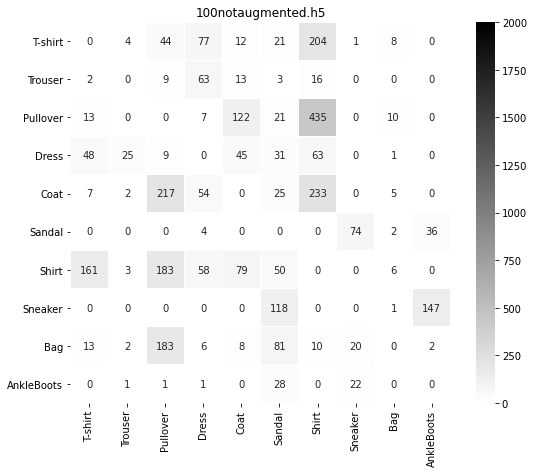

The algorithm misrecognizes  435.0   of class  Pullover  as class  Shirt


<tf.Tensor: shape=(), dtype=float64, numpy=3150.0>

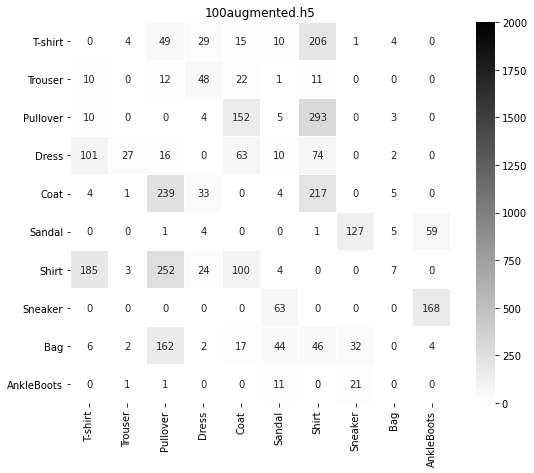

The algorithm misrecognizes  293.0   of class  Pullover  as class  Shirt


<tf.Tensor: shape=(), dtype=float64, numpy=3037.0>

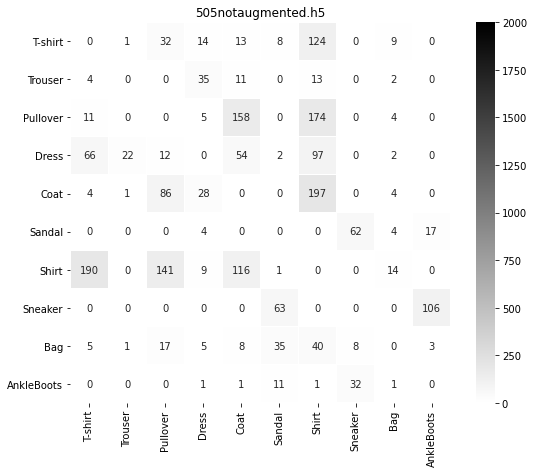

The algorithm misrecognizes  197.0   of class  Coat  as class  Shirt


<tf.Tensor: shape=(), dtype=float64, numpy=2089.0>

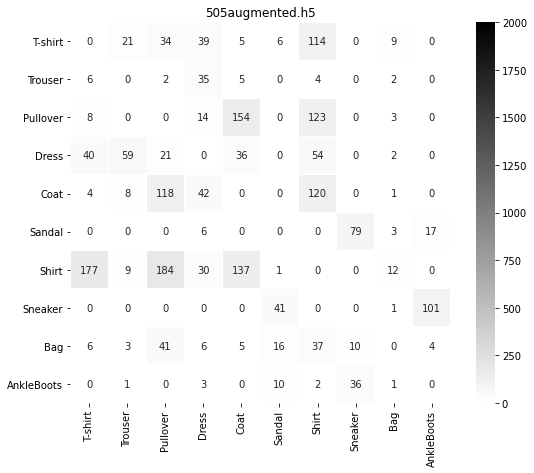

The algorithm misrecognizes  184.0   of class  Shirt  as class  Pullover


<tf.Tensor: shape=(), dtype=float64, numpy=2068.0>

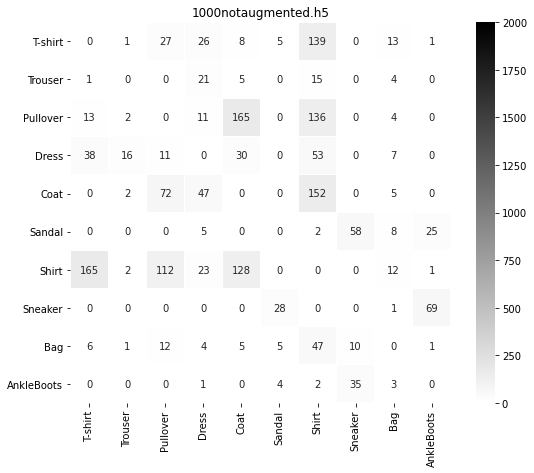

The algorithm misrecognizes  165.0   of class  Pullover  as class  Coat


<tf.Tensor: shape=(), dtype=float64, numpy=1805.0>

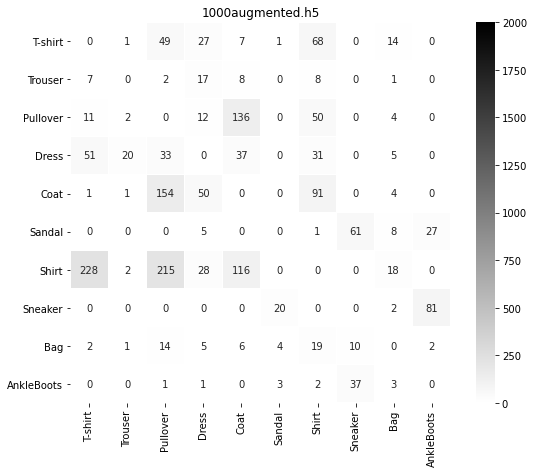

The algorithm misrecognizes  228.0   of class  Shirt  as class  T-shirt


<tf.Tensor: shape=(), dtype=float64, numpy=1825.0>

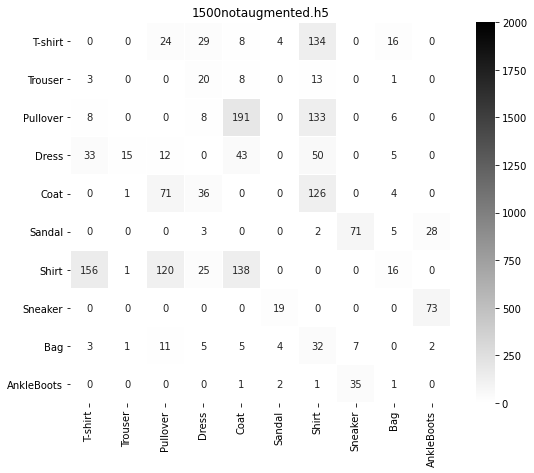

The algorithm misrecognizes  191.0   of class  Pullover  as class  Coat


<tf.Tensor: shape=(), dtype=float64, numpy=1769.0>

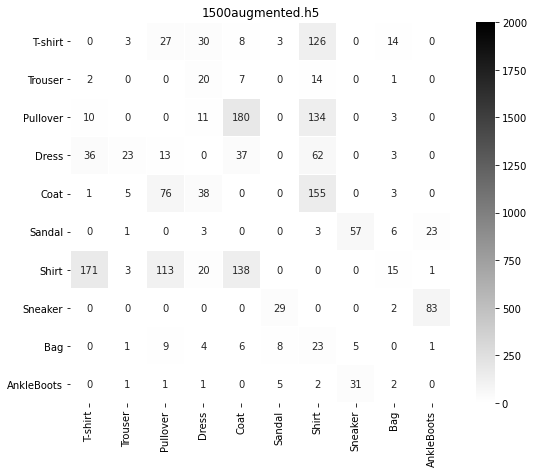

The algorithm misrecognizes  180.0   of class  Pullover  as class  Coat


<tf.Tensor: shape=(), dtype=float64, numpy=1813.0>

In [36]:
# predictions = model.predict(x_test)

# predictions = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1) 

# confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
# #confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))

# f, ax = plt.subplots(figsize=(9, 7))
# sn.heatmap(
#     confusion_matrix,
#     annot=True,
#     linewidths=.5,
#     fmt="d",
#     square=True
#     #,ax=ax
# )
# plt.show()


### Just the confusing part
LABEL_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoots']
modelnames = ['100notaugmented.h5', '100augmented.h5', '505notaugmented.h5', '505augmented.h5', '1000notaugmented.h5', '1000augmented.h5', '1500notaugmented.h5', '1500augmented.h5',]
  
for modelname in modelnames:
  model.load_weights(modelname)

  predictions = model.predict(x_test)
  predictions = np.argmax(predictions, axis=1)
  
  confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
  #confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))
  
  # plot_confusion_matrix(model, x_test, y_test, display_labels=LABEL_NAMES, cmap=plt.cm.Blues, normalize=True)
  title = str(modelname)



  ## I want to pick the largest value on the confusion matrix not on the diagonal
  confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)

  confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)

  # f, ax = plt.subplots(figsize=(9, 7))
  # sn.heatmap(
  #     confusing_part_matrix,
  #     annot=True,
  #     linewidths=.5
  #     ,fmt='.0f'
  #     #,fmt="d"
  #     #,square=True
  #     #,ax=ax
  # )
  # plt.show()


  title = str(modelname)

  f, ax = plt.subplots(figsize=(9, 7))
  sn.heatmap(
      confusing_part_matrix,
      annot=True,
      linewidths=.5
      ,fmt='.0f'
      ,square=True
      ,cmap=plt.cm.gray_r
      ,cbar=True
      ,vmax=2000
      ,xticklabels=LABEL_NAMES
      ,yticklabels=LABEL_NAMES
      #,display_labels=LABEL_NAMES
      #,ax=ax
  )





  
  plt.title(title)
  plt.show()


  ## find the max value of those remaining numbers
  thisnumber=np.max(confusing_part_matrix)

  # x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
  # y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
  # z_thisnumber=np.argmax(confusing_part_matrix)
  # display(x_thisnumber,y_thisnumber)
  # print("The worst the algorithm did is between " confus)
  z_thisnumber=np.argmax(confusing_part_matrix)
  z_thisnumber
  print("The algorithm misrecognizes ", thisnumber, "  of class " ,  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " as class ",  LABEL_NAMES[z_thisnumber%10])


  display(sum(sum(confusing_part_matrix)))

In [ ]:
  # modelaugmented.load_weights(modelname)

  predictions = modelaugmented.predict(x_test)
  predictions = np.argmax(predictions, axis=1)
  y_test = np.argmax(y_test, axis=1) 

  confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
  #confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))

  f, ax = plt.subplots(figsize=(9, 7))
  sn.heatmap(
      confusion_matrix,
      annot=True,
      linewidths=.5,
      fmt="d",
      square=True
      #,ax=ax
  )
  plt.show()